# Risk Factor Clinical Classifier

This classifier takes patient answers to the Lung Space clinical survey and predicts the chance of cancer.

## Import dataset and build dataframe

In [71]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


# Breakdown of positive and negative sample size
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))

# Features
features_demographic = ['age', 'weight', 'height']
features_smoking = ["cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr"]
features_screening = ['num_screens']
features_work_history = ["resasbe","resbaki","resbutc","reschem","resfarm","resfire","resflou","resfoun","reshard","respain","ressand","resweld","wrkasbe","wrkbaki","wrkbutc","wrkchem","wrkcoal","wrkcott","wrkfarm","wrkfire","wrkflou","wrkfoun","wrkhard","wrkpain","wrksand","wrkweld"]
features_disease_history = ["ageadas","ageasbe","agebron","agechas","agechro","agecopd","agediab","ageemph","agehear","agehype","agepneu","agestro","agetube","diagadas","diagasbe","diagbron","diagchas","diagchro","diagcopd","diagdiab","diagemph","diagfibr","diaghear","diaghype","diagpneu","diagsarc","diagsili","diagstro","diagtube"]
features_family_history = ["fambrother","famchild","famfather","fammother","famsister"]
features_alcohol = ["acrin_alc_curr","acrin_alc_ever","acrin_drink24hr","acrin_drinknum_curr","acrin_drinknum_form","acrin_drinkyrs_curr","acrin_drinkyrs_form","acrin_lastdrink","lss_alcohol_freq","lss_alcohol_num"]
output_column = ['lung_cancer']

# All columns to
dataset_columns = features_demographic + features_smoking + features_screening + features_work_history + features_disease_history + features_family_history + features_alcohol + output_column

# Build dataframe
df = df[dataset_columns]
for i in dataset_columns[:]:
  if df[i].isna().sum() > 500:
    df = df.drop(i, axis=1)
    dataset_columns.remove(i)

# print(df.isnull().sum(axis = 0).sort_values(ascending=False).to_string())

df = df.dropna()

# Determines how many negative samples to include in the dataset
# The frac value determines the percent of negative values that are excluded
df = df.drop(df.query('lung_cancer == 0').sample(frac=.95).index)

df = df[df[dataset_columns] >= 0]
# print(df.loc[df.apply(lambda row: all(value < 0 for value in row), axis=1)])
df = df.dropna()
print(df)


/tmp/ipykernel_8662/1627867600.py:8: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


positive:  2058  negative:  51394
       age  weight  height  cigar  cigsmok  pipe   pkyr  smokeage  smokeday  \
11      61   142.0    67.0    1.0        1   1.0  37.00      22.0        20   
37      71   220.0    68.0    0.0        1   0.0  51.00      20.0        20   
44      60   160.0    71.0    0.0        1   0.0  40.50      15.0        18   
48      74   190.0    71.0    0.0        1   0.0  54.00      20.0        20   
54      67   165.0    70.0    0.0        0   0.0  48.00      19.0        20   
...    ...     ...     ...    ...      ...   ...    ...       ...       ...   
53423   57   170.0    72.0    1.0        0   1.0  33.30      15.0        18   
53430   61   190.0    72.0    0.0        0   0.0  67.50      16.0        30   
53431   56   140.0    69.0    0.0        0   0.0  70.00      17.0        40   
53432   55   137.0    61.0    0.0        1   0.0  30.75      14.0        15   
53443   57   230.0    64.0    0.0        0   0.0  37.00      16.0        20   

       smokelive 

## Define models

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    "Naive Bayes",
    "Logistic Regression"
    # "QDA",
]

# Models
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    # MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=0)
    # QuadraticDiscriminantAnalysis(),
]


# Use predict lung_cancer column
# X = df[['age', 'weight', 'height', "cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr","num_screens"]]
X = df[dataset_columns[:-1]]
y = df[['lung_cancer']]

# Spli training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print(y_train)
print(y_test)

print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_train['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_train['lung_cancer'].to_list()))))
print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_test['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_test['lung_cancer'].to_list()))))


       lung_cancer
12570            1
21465            0
48046            1
24898            0
20779            1
...            ...
53181            0
5568             0
37145            1
45137            1
9984             0

[2670 rows x 1 columns]
       lung_cancer
9351             1
45916            0
29053            1
50047            1
14815            0
...            ...
52692            0
21411            0
8819             0
53263            1
46766            1

[1780 rows x 1 columns]
positive training sample:  1165
negative training sample:  1505
positive training sample:  805
negative training sample:  975


## Test models and plot confusion matrices

The goal is to minimize the number of false negative predictions.

Model:  Nearest Neighbors  score:  0.6005617977528089


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:  Linear SVM  score:  0.6865168539325842
Model:  Decision Tree  score:  0.6797752808988764
Model:  Naive Bayes  score:  0.5842696629213483
Model:  Logistic Regression  score:  0.6898876404494382


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


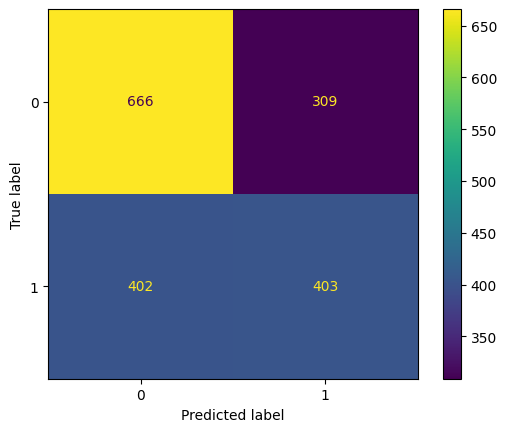

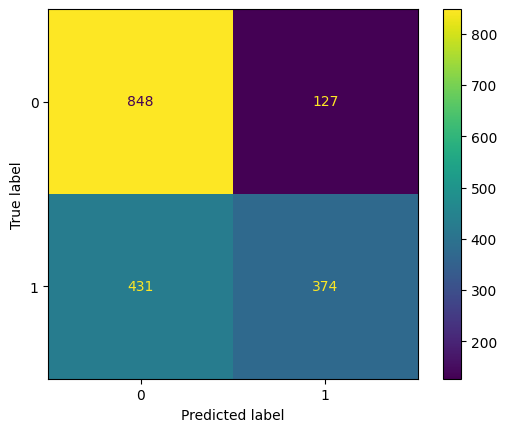

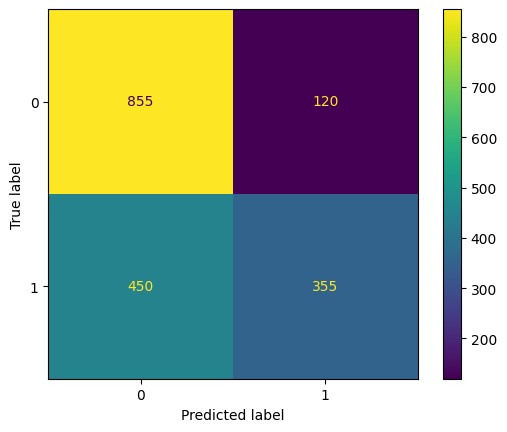

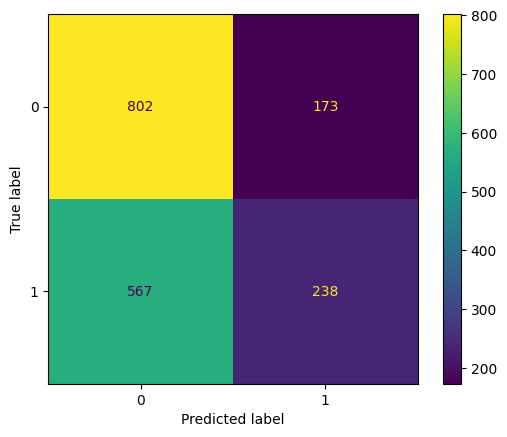

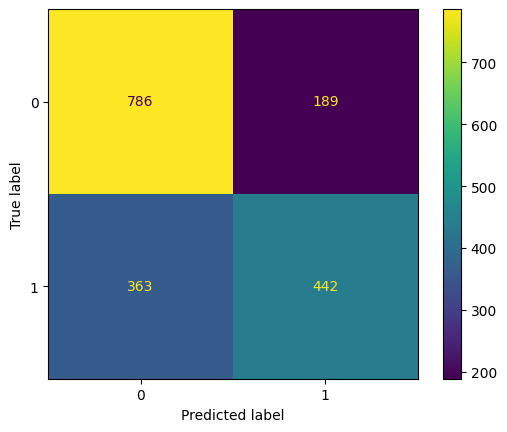

In [73]:
for name, clf in zip(names, classifiers):
  clf = make_pipeline(StandardScaler(), clf)
  clf.fit(normalize(X_train), y_train)
  y_pred = clf.predict(normalize(X_test))

  score = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
  disp.plot()
  print("Model: ", name, " score: ", score)


## Get confidence of each prediction with `predict_proba()`

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model:  Logistic Regression  score:  0.6898876404494382


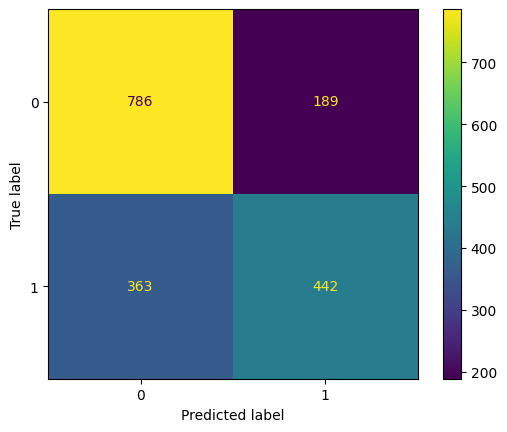

In [74]:
# Fit logistic regression model
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

# Get confidence intervals for each prediction
y_pred_prob = model.predict_proba(X_test)
# Get predicted values
y_pred = clf.predict(normalize(X_test))

# Get prediction accuracy
score = accuracy_score(y_test, y_pred)
# Get breakdown of false/true positives and false/true negatives
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", name, " score: ", score)


## Rank features used 

In [75]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = model.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('num_screens', -0.9361881814784112), ('diagcopd', 0.43512509356362533), ('diaghear', 0.2965283165381685), ('wrkfarm', 0.27516769944776354), ('diagpneu', 0.2682100791563691), ('wrkweld', 0.23787867007620628), ('diagemph', 0.217524280166794), ('smokework', 0.16046044091269845), ('smokelive', -0.12817211250235397), ('wrkfoun', 0.11835962672377867), ('wrkasbe', -0.10362854168185268), ('wrkpain', 0.10177424918707563), ('diaghype', -0.07996749905147676), ('wrkflou', 0.07718307174217837), ('cigsmok', -0.07688989051351607), ('diagasbe', 0.07356360637128188), ('wrkchem', 0.06799377106554749), ('smokeyr', 0.06125434450072271), ('cigar', 0.06059422123606276), ('diagchas', 0.059309324633966994), ('diagadas', 0.0558655192965622), ('wrkcoal', 0.05541844196446606), ('pipe', 0.05520549682038865), ('wrkbaki', 0.05359364675887086), ('diagchro', 0.04830400908462129), ('diagstro', -0.04775306986715748), ('diagdiab', -0.047521623813734426), ('wrkfire', 0.04290387673104949), ('height', -0.0268774382553802

## Compare compare the probabilities of false positives and false negatives to true positives and true negatives

In [76]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


## Plot the confidence intervals that led to the different predictions. 

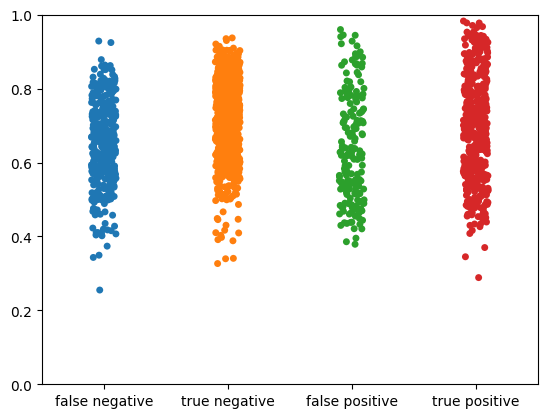

In [77]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()
